In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

# SELLER P&L ANALYSIS

The goal of this exercise is to compute, for each `seller_id`:

- The **revenue** it brings (10% of each sales + 80 BRL per month)
- The **cost** associated with all its bad reviews (1-star = 100 BRL, 2-star = 50, 3-star=40)
- The resulting **profit** made by Olist for each seller

❓ Let's not start all again from scratch! Import your seller training set and investigate what you already have.


In [ ]:
from olist.seller import Seller
seller = Seller()

In [ ]:
sellers = seller.get_training_data()
sellers.head()

❓ What is missing? Write down a strategy to get your missing columns, by re-using as much of  what has already been coded in `seller.py` as possible

In [ ]:
# Your pseudo-code

❓ Update `seller.py` accordingly

Correction below, updated in `seller_updated.py`

TODO: Show students how to update their code and print results in their notebook. Debug using ipdb.set_trace() when needed

```python
def get_review_score(self):

        matching_table = self.matching_table
        orders_reviews = self.order.get_review_score()
        matching_table = matching_table[['order_id', 'seller_id']].drop_duplicates()
        df = matching_table.merge(orders_reviews, on='order_id')

        # Compute the costs
        df['cost_of_review'] = df.review_score.map({
            1: 100,
            2: 50,
            3: 40,
            4: 0,
            5: 0
        })

        df = df.groupby('seller_id',
                        as_index=False).agg({'dim_is_one_star': 'mean',
                                             'dim_is_five_star': 'mean',
                                             'review_score': 'mean',
                                             'cost_of_review': 'sum'}) # new column added here
        df.columns = ['seller_id', 'share_of_one_stars',
                      'share_of_five_stars', 'review_score', 'cost_of_reviews']

        return df

❓ Compute seller profits

updated code below

```python
def get_training_data(self):

    training_set =\
        self.get_seller_features()\
            .merge(
            self.get_seller_delay_wait_time(), on='seller_id'
           ).merge(
            self.get_active_dates(), on='seller_id'
           ).merge(
            self.get_review_score(), on='seller_id'
           ).merge(
            self.get_quantity(), on='seller_id'
           ).merge(
            self.get_sales(), on='seller_id'
           )
    # Add seller economics (revenues, profits)
    olist_monthly_fee = 80
    olist_sales_cut = 0.1

    training_set['revenues'] = training_set['months_on_olist'] * olist_monthly_fee\
        + olist_sales_cut * training_set['sales']

    training_set['profits'] = training_set['revenues'] - training_set['cost_of_reviews']

    return training_set
```

❓ Load your updated DataFrame

In [5]:
from olist.seller_updated import Seller as SellerUpdated
sellers = SellerUpdated().get_training_data()

❓ Sort sellers by profit, and analyse their profitability: conclude on a possible strategy for Olist!

Text(0.5, 0, 'seller id')

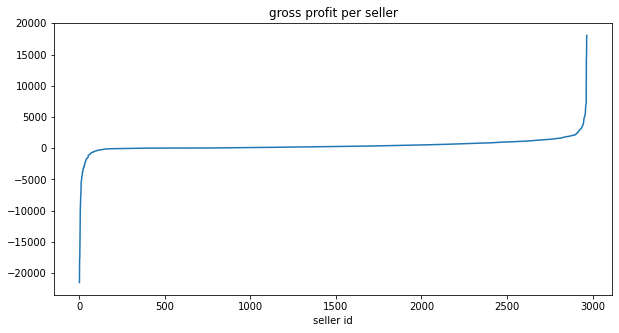

In [6]:
sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

plt.figure(figsize=(10,5))
sorted_sellers.profits.plot()
plt.title('gross profit per seller')
plt.xlabel('seller id')

# Going further

## Profits per seller removed before IT costs

We should look at the effect of removing sellers on the total profits of Olist.

### Total profits for Olist
Let's first calculate Olist's total profits.

In [19]:
olist_total_profits = sorted_sellers.profits.sum()

print(f"Olist's total profits were BRL {olist_total_profits:,.0f}.")

Olist's total profits were BRL 1,167,608.


### Cumulative profits from sellers

What are the profits when we add each seller one by one (from worst to best)?

<AxesSubplot:>

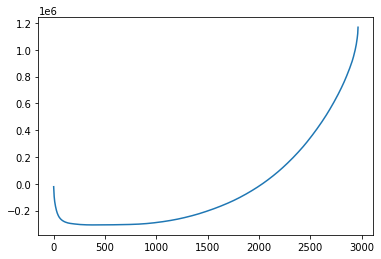

In [23]:
sorted_sellers.cumsum().profits.plot()

☝️ This shows that Olist loses money with about 300 of its worst performing sellers. They need the 2000 "worst" performing sellers to break even.

Let's look at it the other way around. Olist's total profits were BRL 1,167,608. What if we removed the worst sellers one by one?

<AxesSubplot:>

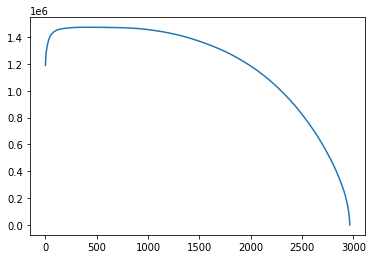

In [24]:
profits_per_removed_seller_before_it_costs = olist_total_profits - sorted_sellers.cumsum().profits

profits_per_removed_seller_before_it_costs.plot()

Let's define a function to plot the maximum of that curve:

In [26]:
def plot_max(series):
    max_idx = series.idxmax()
    max_value = series.iloc[max_idx]
    plt.scatter(max_idx, max_value, color="red")
    plt.text(max_idx, 0, f"Max:\n{max_value:.2f}\nfor index {max_idx}")
    return max_idx, max_value

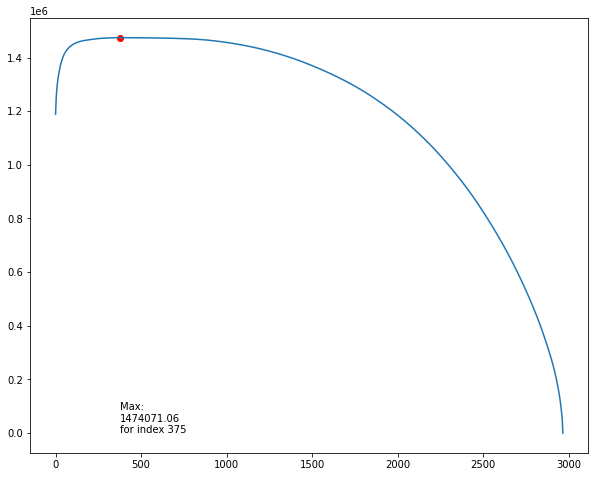

In [27]:
# Plot the cumulative sum curve
plt.figure(figsize=(10,8))
profits_per_removed_seller_before_it_costs.plot()

# Plot the max profits as a single dot
max_idx, max_value = plot_max(profits_per_removed_seller_before_it_costs)

## Let's factor in the IT costs



<AxesSubplot:>

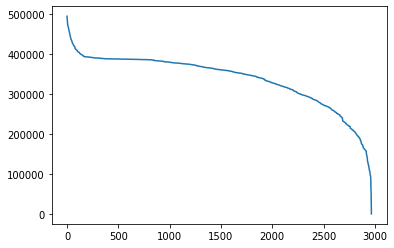

In [179]:
# Total number of orders
olist_total_orders = sorted_sellers.n_orders.sum()

# Orders per removed seller
n_orders_per_removed_seller = olist_total_orders - sorted_sellers.cumsum().n_orders

# Proportionality factor
total_it_costs = 500_000
# total_it_costs = alpha * olist_total_orders ** 0.5
alpha = total_it_costs / olist_total_orders ** 0.5

# IT costs per removed seller
total_it_costs_per_removed_seller = alpha * n_orders_per_removed_seller ** 0.5

total_it_costs_per_removed_seller.plot()

<AxesSubplot:>

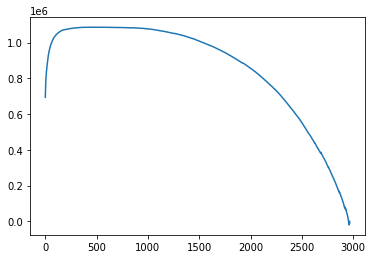

In [180]:
# Total number of orders
olist_total_orders = sorted_sellers.n_orders.sum()

# Orders per removed seller
n_orders_per_removed_seller = olist_total_orders - sorted_sellers.cumsum().n_orders

# Proportionality factor
total_it_costs = 500_000
# total_it_costs = alpha * olist_total_orders ** 0.5
alpha = total_it_costs / olist_total_orders ** 0.5

# IT costs per removed seller
total_it_costs_per_removed_seller = alpha * n_orders_per_removed_seller ** 0.5

# Profits
profits_per_removed_seller = profits_per_removed_seller_before_it_costs - total_it_costs_per_removed_seller
profits_per_removed_seller.plot()

(485, 0.38966835275617917)

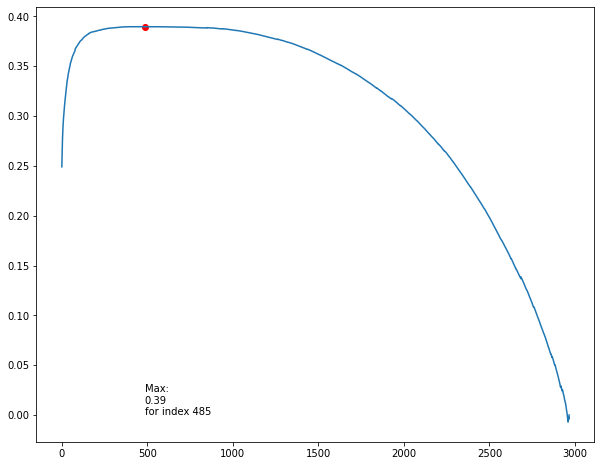

In [181]:
# Revenues per seller
revenues_per_removed_seller =  sorted_sellers.revenues.sum()

# Profit margins
profit_margins_per_removed_seller = profits_per_removed_seller / revenues_per_removed_seller

plt.figure(figsize=(10,8))
profit_margins_per_removed_seller.plot()
plot_max(profit_margins_per_removed_seller)